In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# plt.style.use('dark_background')
import h5py
import skopt
import scipy as sc
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor as GPR
from skopt.learning.gaussian_process.kernels import Matern, WhiteKernel, Product, ConstantKernel
%run ./Functions_Test.ipynb
%run ./Val_Functions.ipynb
import matplotlib as mpl
import time
import math
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

### Dataset generation

(1438, 4000, 9) (5752000, 9)
[0.00463421 0.00274448 0.00154149 0.0014369  0.00280263 0.00324911
 0.00284277 0.00143675 0.00143555]


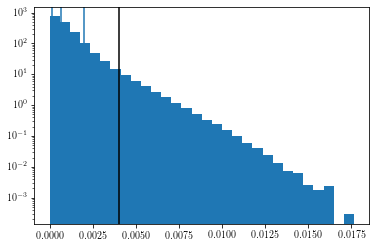

0.05985675025751997 0.0631508261395143
61 1
62.57377049180328


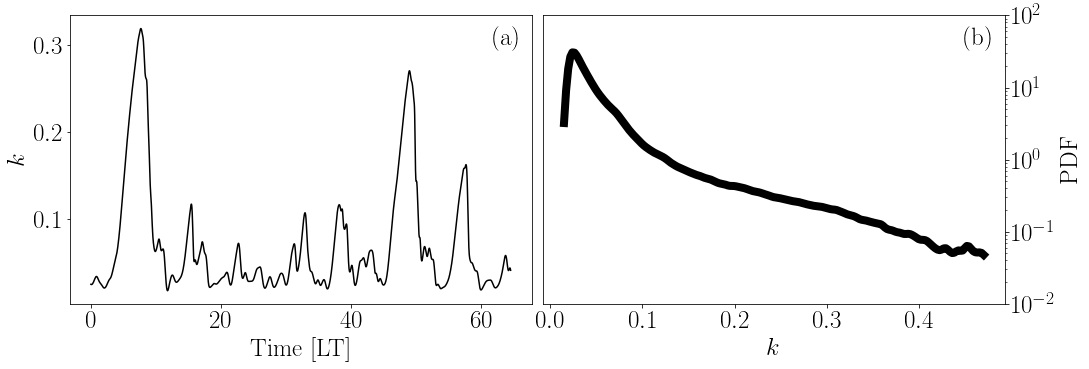

In [2]:
Ndim      = 9
idx       = range(Ndim)
idx1      = idx

hf       = h5py.File('./data/MFE_Sri_RK4_dt=0.25kt=048.h5','r')
UU       = np.array(hf.get('q'))[:,::4,idx]
hf.close()


N1_val = 10

N0 = UU.shape[0]
N1 = UU.shape[1]
U = UU.reshape(N0*N1, Ndim)
print(UU.shape, U.shape)

# Set a target SNR in decibel
target_snr_db = 30
sig_avg_watts = np.var(U,axis=0) #signal power
sig_avg_db = 10 * np.log10(sig_avg_watts) #convert in decibel
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
print(np.sqrt(noise_avg_watts))
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.zeros(U.shape)
seed = 0                        #to be able to recreate the data
rnd  = np.random.RandomState(seed)
for i in range(Ndim):
    noise_volts[:,i] = rnd.normal(mean_noise, np.sqrt(noise_avg_watts[i]),
                                       U.shape[0])

UUU  = U + noise_volts

# UUU  = UUU.reshape(N0,N1,Ndim)


kinetic   = 0.5*np.linalg.norm(U,axis=1)**2
kin_noise = 0.5*np.linalg.norm(UUU,axis=1)**2

mean_k    = np.mean(kinetic)
plt.yscale('log')
threshold = (.1-mean_k)/10
plt.hist(np.abs(kinetic-kin_noise),density=True,bins=30)
q1 = .1 ; q2 = 1-q1
plt.axvline(threshold,c='k')
plt.axvline(np.median(np.abs(kinetic-kin_noise)))
plt.axvline(np.quantile(np.abs(kinetic-kin_noise),q1))
plt.axvline(np.quantile(np.abs(kinetic-kin_noise),q2))
plt.show()

print(np.mean(kinetic), np.std(kinetic))

t_lyap    = 0.0163**(-1)    # Lyapunov time
dt        = 1      # timestep 
N_lyap    = int(t_lyap/dt)  # number of time steps in one Lyapunov time
print(N_lyap, dt)

# number of time steps for washout, train, validation, test
N_washout = N_lyap #1*N_lyap
N_train   = N1 - 2*N_lyap - N_washout # 196*N_lyap
N_val     = 2*N_lyap
N_test    = 500*N_lyap

print(N_train/N_lyap)

#compute norm
U_data = U[:N_washout+N_train+N_val]
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m

UUU  = UUU.reshape(N0,N1,Ndim)

# washout
U_washout = UU[:N1_val,:N_washout]
# training
U_t   = UU[:N1_val,N_washout:N_washout+N_train-1]
Y_t   = UU[:N1_val,N_washout+1:N_washout+N_train]
# training + validation
U_tv  = UU[:N1_val,N_washout:N_washout+N_train+N_val-1]
Y_tv  = UU[:N1_val,N_washout+1:N_washout+N_train+N_val]
NN    = N1_val
k_tv  = 0.5*np.linalg.norm(UUU[:NN].reshape(NN*N1, Ndim), axis=1)**2
# validation
Y_v  = UU[:N1_val,N_washout+N_train:N_washout+N_train+N_val]

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
ax, fig = plt.subplots(1,2)

plt.subplot(121)
plt.axhline(0.1,'k', alpha=.3)
plt.plot(np.arange(N_train+N_val-1)/N_lyap,
                  0.5*np.linalg.norm(U_tv[0,:,idx].T,axis=1)**2, c='k')
plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.ylabel('$k$')
plt.xlabel('Time [LT]')

axx = plt.subplot(122)
N_range=(0.015,0.48)
N_rang1=(0.015,N_range[1]-0.01)
plt.ylim(0.01,100)
axx.yaxis.set_label_position("right")
axx.yaxis.tick_right()
Y_stats = kinetic
mask    = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
Y_stats = Y_stats[mask]
density1 = sc.stats.gaussian_kde(Y_stats)
n, y, _ = plt.hist(Y_stats, bins=200, range=N_rang1, # bins=np.linspace(minn,maxx, 100) 
                   histtype=u'step', density=True, log=True, alpha=0.001, color='k')
dy      = density1(y)
plt.plot(y, dy, label='True', linewidth=8, c='black')
plt.xlabel('$k$')
plt.ylabel('PDF')
plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

ax.tight_layout(pad=0.1)
plt.savefig('k_time_pdf.pdf')

plt.show()

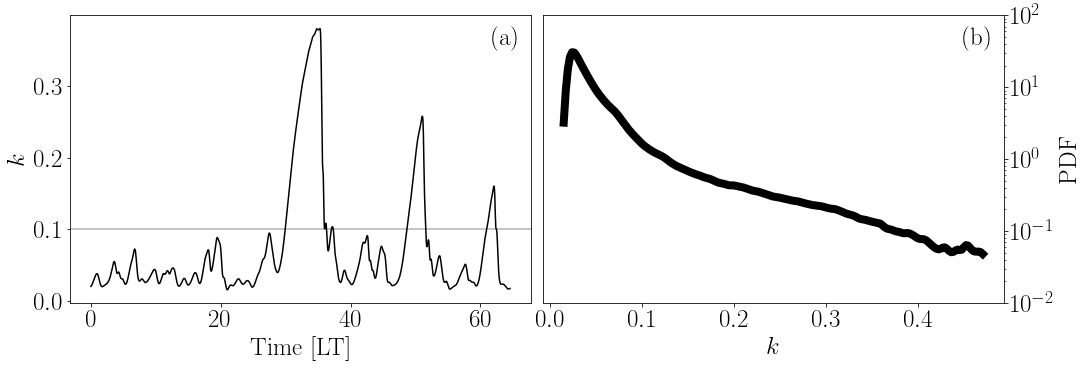

In [9]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
ax, fig = plt.subplots(1,2)

plt.subplot(121)
plt.axhline(0.1,color='k', alpha=.3)
plt.plot(np.arange(N_train+N_val-1)/N_lyap,
                  0.5*np.linalg.norm(U_tv[5,:,idx].T,axis=1)**2, c='k')
plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.ylabel('$k$')
plt.xlabel('Time [LT]')

axx = plt.subplot(122)
N_range=(0.015,0.48)
N_rang1=(0.015,N_range[1]-0.01)
plt.ylim(0.01,100)
axx.yaxis.set_label_position("right")
axx.yaxis.tick_right()
# Y_stats = kinetic
# mask    = (Y_stats < N_range[1]) & (Y_stats > N_range[0])
# Y_stats = Y_stats[mask]
# density1 = sc.stats.gaussian_kde(Y_stats)
n, y, _ = plt.hist(Y_stats, bins=200, range=N_rang1, # bins=np.linspace(minn,maxx, 100) 
                   histtype=u'step', density=True, log=True, alpha=0.001, color='k')
# dy      = density1(y)
plt.plot(y, dy, label='True', linewidth=8, c='black')
plt.xlabel('$k$')
plt.ylabel('PDF')
plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

ax.tight_layout(pad=0.12)
plt.savefig('k_time_pdf.pdf')

plt.show()

## Prediction Horizon of Extreme Events

0.19887640449438201
1000
RVC 5.310450005674725 5.41547497446374 5.546546929973897

0.3471910112359551
1500
RVC 6.203424696402225 6.334553399160141 6.460801838610828

0.40786516853932586
2000
RVC 6.576878333900806 6.630518669844513 6.676115083418455

0.4202247191011236
2500
RVC 6.579900124843946 6.664935875610033 6.779139711723983

0.4544943820224719
3000
RVC 6.752057087731245 6.793553512654636 6.852939507433891

0.025093632958801498
1000
RVC 3.7366643967767557 3.950998751560549 4.0591164453524

0.05393258426966292
1500
RVC 4.3635370559527855 4.485955056179776 4.527366360231529

0.06647940074906367
2000
RVC 4.730791056633754 4.774599931903303 4.8538049029622075

0.07434456928838952
2500
RVC 4.707850981727386 4.8722051980478955 4.989714561343775

0.08333333333333333
3000
RVC 4.879539779820679 5.034700942004313 5.052760753603451

0.0026217228464419477
0.004307116104868914
0.00018726591760299626
0.00149812734082397
1000
SSV 1.4249092044035863 1.7678186357961638 2.3630688911587785
RVC 2.340

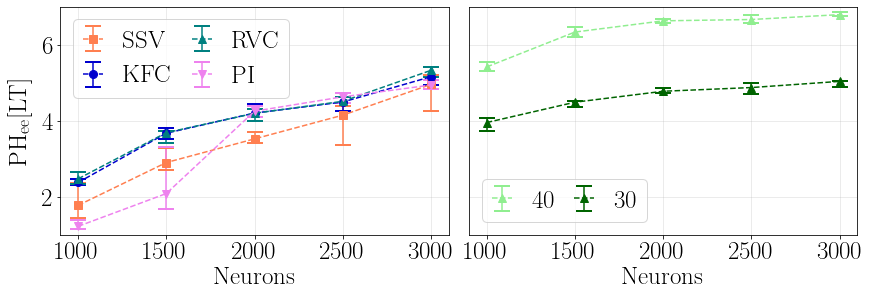

In [83]:
plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["font.size"] = 25

plt.figure()
plt.subplot(122)

NN_units  = [1000,1500,2000,2500,3000]
SNRs      = [40,30]
un_length = len(NN_units)

a_KFC     = np.zeros((un_length,3))
a_RVC     = np.zeros((un_length,3))
a_SSV     = np.zeros((un_length,3))
a_PI      = np.zeros((un_length,3))

markers = ['s', 'o', '^', 'v']
labels  = [ str(SNRs[i]) for i in range(len(SNRs))]
colors  = ['lightgreen', 'darkgreen']

k = 0
for target_snr_db in SNRs:
    i         = 0
    for N_units in NN_units:

    #     fln   = './data/KFC_PHEE_' + str(target_snr_db) + '_' + str(N_units) +'.h5'
    #     hf    = h5py.File(fln,'r')
    #     t_KFC = np.array(hf.get('PH'))
    #     print(np.count_nonzero(t_KFC > 7.9)/5340)
    #     t_KFC = t_KFC.mean(axis=1)
    #     hf.close()

        fln   = './data/RVC_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        hf    = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('PH'))
        print(np.count_nonzero(t_RVC > 7.9)/5340)
        t_RVC = t_RVC.mean(axis=1)
        hf.close()

    #     fln   = './data/RVC_PI_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
    #     hf    = h5py.File(fln,'r')
    #     t_RPI = np.array(hf.get('PH'))
    #     print(np.count_nonzero(t_RPI > 7.9)/5340)
    #     t_RPI = t_RPI.mean(axis=1)
    #     hf.close()

    #     fln   = './data/SSV_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
    #     hf    = h5py.File(fln,'r')
    #     t_SSV = np.array(hf.get('PH'))
    #     print(np.count_nonzero(t_SSV > 7.9)/5340)
    #     t_SSV = t_SSV.mean(axis=1)
    #     hf.close()

        q1 = .25
        q2 = 1 - q1

    #     a_SSV[i] = [np.quantile(t_SSV,q1,axis=0),np.median(t_SSV,axis=0),np.quantile(t_SSV,q2,axis=0)]
        a_RVC[i] = [np.quantile(t_RVC,q1,axis=0),np.median(t_RVC,axis=0),np.quantile(t_RVC,q2,axis=0)]
    #     a_KFC[i] = [np.quantile(t_KFC,q1,axis=0),np.median(t_KFC,axis=0),np.quantile(t_KFC,q2,axis=0)]
    #     a_PI [i] = [np.quantile(t_RPI,q1,axis=0),np.median(t_RPI,axis=0),np.quantile(t_RPI,q2,axis=0)]

        i +=1

        print(N_units)
    #     print('SSV',np.quantile(t_SSV,q1,axis=0),np.median(t_SSV,axis=0),np.quantile(t_SSV,q2,axis=0))
        print('RVC',np.quantile(t_RVC,q1,axis=0),np.median(t_RVC,axis=0),np.quantile(t_RVC,q2,axis=0))
    #     print('KFC',np.quantile(t_KFC,q1,axis=0),np.median(t_KFC,axis=0),np.quantile(t_KFC,q2,axis=0))
    #     print('RPI',np.quantile(t_RPI,q1,axis=0),np.median(t_RPI,axis=0),np.quantile(t_RPI,q2,axis=0))
        print('')

    x = NN_units
    plt.xticks(x)

    plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

    # plt.errorbar(x, a_SSV[:,1], 
    #              yerr = np.array([a_SSV[:,1] - a_SSV[:,0],
    #                               a_SSV[:,2] - a_SSV[:,1]]), 
    #              linestyle='--',color='coral', marker='s', markersize=8,
    #              capsize=8, capthick=2, label='SSV', alpha=1)
    # plt.errorbar(x, a_KFC[:,1], 
    #              yerr = np.array([a_KFC[:,1] - a_KFC[:,0],
    #                               a_KFC[:,2] - a_KFC[:,1]]), 
    #              linestyle='--',color='mediumblue', marker='o', markersize=8,
    #              capsize=8, capthick=2, label='KFC', alpha=1)

    plt.errorbar(x, a_RVC[:,1], 
                 yerr = np.array([a_RVC[:,1] - a_RVC[:,0],
                                  a_RVC[:,2] - a_RVC[:,1]]), 
                 linestyle='--',color=colors[k], marker=markers[2], markersize=8,
                 capsize=8, capthick=2, label=labels[k], alpha=1)

    # plt.errorbar(x, a_PI[:,1], 
    #              yerr = np.array([a_PI[:,1] - a_PI[:,0],
    #                               a_PI[:,2] - a_PI[:,1]]), 
    #              linestyle='--',color='violet', marker='v', markersize=8,
    #              capsize=8, capthick=2, label='PI', alpha=1)
    k+=1

plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
# plt.ylabel('$\mathrm{PH}_{\mathrm{ee}}$[LT]', labelpad=10)
plt.xlabel('Neurons')
plt.legend(ncol=2, frameon=True, columnspacing=0.8, handlelength=0.8)
plt.ylim(1,7)

plt.subplot(121)

NN_units  = [1000,1500,2000,2500,3000]
un_length = len(NN_units)

a_KFC     = np.zeros((un_length,3))
a_RVC     = np.zeros((un_length,3))
a_SSV     = np.zeros((un_length,3))
a_PI      = np.zeros((un_length,3))

i         = 0

for N_units in NN_units:

    fln   = '../MFE_Sri/data/KFC_PHEE_'+  str(N_units) +'.h5'
    hf    = h5py.File(fln,'r')
    t_KFC = np.array(hf.get('PH'))
    print(np.count_nonzero(t_KFC > 7.9)/5340)
    t_KFC = t_KFC.mean(axis=1)
    hf.close()

    fln   = '../MFE_Sri/data/RVC_PHEE_'+  str(N_units) +'.h5'
    hf    = h5py.File(fln,'r')
    t_RVC = np.array(hf.get('PH'))
    print(np.count_nonzero(t_RVC > 7.9)/5340)
    t_RVC = t_RVC.mean(axis=1)
    hf.close()

    fln   = '../MFE_Sri/data/RVC_PI2_PHEE_'+  str(N_units) +'.h5'
    hf    = h5py.File(fln,'r')
    t_RPI = np.array(hf.get('PH'))
    print(np.count_nonzero(t_RPI > 7.9)/5340)
    t_RPI = t_RPI.mean(axis=1)
    hf.close()

    fln   = '../MFE_Sri/data/SSV_PHEE_'+  str(N_units) +'.h5'
    hf    = h5py.File(fln,'r')
    t_SSV = np.array(hf.get('PH'))
    print(np.count_nonzero(t_SSV > 7.9)/5340)
    t_SSV = t_SSV.mean(axis=1)
    hf.close()

    q1 = .25
    q2 = 1 - q1
    
    a_SSV[i] = [np.quantile(t_SSV,q1,axis=0),np.median(t_SSV,axis=0),np.quantile(t_SSV,q2,axis=0)]
    a_RVC[i] = [np.quantile(t_RVC,q1,axis=0),np.median(t_RVC,axis=0),np.quantile(t_RVC,q2,axis=0)]
    a_KFC[i] = [np.quantile(t_KFC,q1,axis=0),np.median(t_KFC,axis=0),np.quantile(t_KFC,q2,axis=0)]
    a_PI [i] = [np.quantile(t_RPI,q1,axis=0),np.median(t_RPI,axis=0),np.quantile(t_RPI,q2,axis=0)]
    
    i +=1
    
    print(N_units)
    print('SSV',np.quantile(t_SSV,q1,axis=0),np.median(t_SSV,axis=0),np.quantile(t_SSV,q2,axis=0))
    print('RVC',np.quantile(t_RVC,q1,axis=0),np.median(t_RVC,axis=0),np.quantile(t_RVC,q2,axis=0))
    print('KFC',np.quantile(t_KFC,q1,axis=0),np.median(t_KFC,axis=0),np.quantile(t_KFC,q2,axis=0))
    print('RPI',np.quantile(t_RPI,q1,axis=0),np.median(t_RPI,axis=0),np.quantile(t_RPI,q2,axis=0))
    print('')
    
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["font.size"] = 25
x = NN_units
plt.xticks(x)

plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

plt.errorbar(x, a_SSV[:,1], 
             yerr = np.array([a_SSV[:,1] - a_SSV[:,0],
                              a_SSV[:,2] - a_SSV[:,1]]), 
             linestyle='--',color='coral', marker='s', markersize=8,
             capsize=8, capthick=2, label='SSV', alpha=1)
plt.errorbar(x, a_KFC[:,1], 
             yerr = np.array([a_KFC[:,1] - a_KFC[:,0],
                              a_KFC[:,2] - a_KFC[:,1]]), 
             linestyle='--',color='mediumblue', marker='o', markersize=8,
             capsize=8, capthick=2, label='KFC', alpha=1)

plt.errorbar(x, a_RVC[:,1], 
             yerr = np.array([a_RVC[:,1] - a_RVC[:,0],
                              a_RVC[:,2] - a_RVC[:,1]]), 
             linestyle='--',color='teal', marker='^', markersize=8,
             capsize=8, capthick=2, label='RVC', alpha=1)

plt.errorbar(x, a_PI[:,1], 
             yerr = np.array([a_PI[:,1] - a_PI[:,0],
                              a_PI[:,2] - a_PI[:,1]]), 
             linestyle='--',color='violet', marker='v', markersize=8,
             capsize=8, capthick=2, label='PI', alpha=1)


plt.ylabel('$\mathrm{PH}_{\mathrm{ee}}$[LT]', labelpad=10)
plt.xlabel('Neurons')
plt.legend(ncol=2, frameon=True, columnspacing=0.8, handlelength=0.8)
plt.ylim(1,7)

plt.tight_layout(pad=0.1)
plt.savefig('Noise_PHEE_Comp.pdf')


(10, 500)
0.094
(10, 500)
0.04
(10, 500)
0.088
(10, 500)
0.092
(10, 500)
0.14
(10, 500)
0.136
(10, 500)
0.212
(10, 500)
0.11
6552.0 362.0
12053.0 369.0
11847.0 197.0
11504.0 128.0


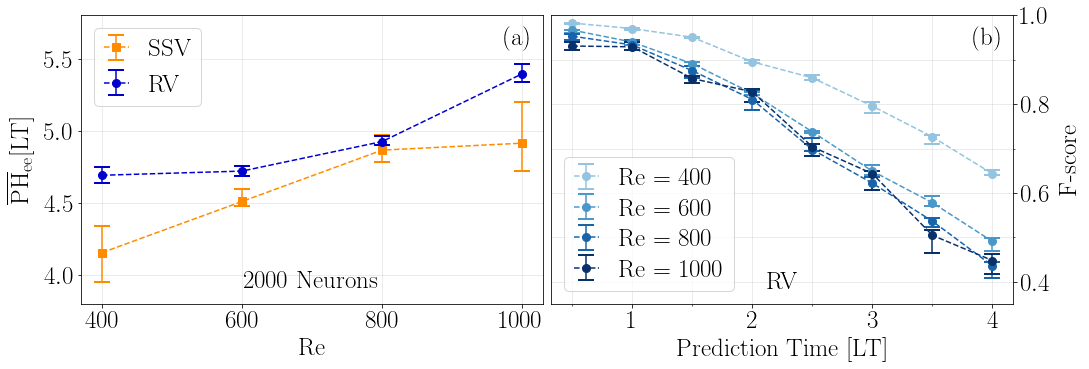

In [11]:
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25

plt.figure()
ax = plt.subplot(121)

Reys      = [400,600,800,1000]
NN_units  = [2000] #add 3500 for tikhonov up to 10e-11
SNRs      = [40]
un_length = len(NN_units)
Re_length = len(Reys)

a_RVC     = np.zeros((Re_length,3))
a_RVC4    = np.zeros((Re_length,3))
a_SSV     = np.zeros((Re_length,3))

markers = ['s', 'o', '^', 'v']
# labels  = ['RVC', 'SSV']
labels  = ['RV','SSV']
colors  = ['mediumblue', 'darkorange', 'coral', 'violet']

norm    = np.ones(un_length)#np.array([0.0159,0.0136,0.0126,0.0121])/0.0296


k = 0
for Re in Reys:
    for target_snr_db in SNRs:
        i         = 0
        for N_units in NN_units:


            fln   = './data/'+str(Re)+'_RVC_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
            hf    = h5py.File(fln,'r')
            t_RVC = np.array(hf.get('PH'))
            print(t_RVC.shape)
            print(np.count_nonzero(t_RVC > 9.9)/500)
            t_RVC = t_RVC.mean(axis=1)#*[norm[k]]
            hf.close()
            
            fln   = './data/'+str(Re)+'_SSV_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
            hf    = h5py.File(fln,'r')
            t_SSV = np.array(hf.get('PH'))
            print(t_SSV.shape)
            print(np.count_nonzero(t_SSV > 9.9)/500)
            t_SSV = t_SSV.mean(axis=1)#*[norm[k]]
            hf.close()
            
#             fln   = './data/400_'+str(Re)+'_RVC_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
#             hf    = h5py.File(fln,'r')
#             t_RVC4 = np.array(hf.get('PH'))
#             print(np.count_nonzero(t_RVC4 > 9.9)/5340)
#             t_RVC4 = t_RVC4.mean(axis=1)
#             hf.close()


#             fln   = './data/SSV_PHEE_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'

#             hf    = h5py.File(fln,'r')
#             t_SSV = np.array(hf.get('PH'))
#             print(np.count_nonzero(t_SSV > 9.9)/5340)
#             t_SSV = t_SSV.mean(axis=1)
#             hf.close()

            q1 = .25
            q2 = 1 - q1

            a_RVC[k] = [np.quantile(t_RVC,q1,axis=0),np.median(t_RVC,axis=0),
                        np.quantile(t_RVC,q2,axis=0)]
#             a_RVC4[k] = [np.quantile(t_RVC4,q1,axis=0),np.median(t_RVC4,axis=0),
#                          np.quantile(t_RVC4,q2,axis=0)]
            a_SSV[k] = [np.quantile(t_SSV,q1,axis=0),np.median(t_SSV,axis=0),
                        np.quantile(t_SSV,q2,axis=0)]
            i +=1


        x = Reys
        plt.xticks(x)

        plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

        if k ==0:
            plt.errorbar(x[k], a_SSV[k,1], 
                         yerr = np.array([a_SSV[k,1] - a_SSV[k,0],
                                          a_SSV[k,2] - a_SSV[k,1]]).reshape(2,1), 
                         linestyle='--',color=colors[1], marker=markers[0], markersize=8,
                         capsize=8, capthick=2, label=labels[1], alpha=1)
            plt.errorbar(x[k], a_RVC[k,1], 
                         yerr = np.array([a_RVC[k,1] - a_RVC[k,0],
                                          a_RVC[k,2] - a_RVC[k,1]]).reshape(2,1), 
                         linestyle='--',color=colors[0], marker=markers[1], markersize=8,
                         capsize=8, capthick=2, label=labels[0], alpha=1)
        else:
            plt.errorbar(x[k], a_SSV[k,1], 
                         yerr = np.array([a_SSV[k,1] - a_SSV[k,0],
                                          a_SSV[k,2] - a_SSV[k,1]]).reshape(2,1), 
                         linestyle='--',color=colors[1], marker=markers[0], markersize=8,
                         capsize=8, capthick=2, alpha=1)
            plt.errorbar(x[k], a_RVC[k,1], 
                         yerr = np.array([a_RVC[k,1] - a_RVC[k,0],
                                          a_RVC[k,2] - a_RVC[k,1]]).reshape(2,1), 
                         linestyle='--',color=colors[0], marker=markers[1], markersize=8,
                         capsize=8, capthick=2, alpha=1)

    k+=1

plt.plot(x, a_RVC[:,1], '--', color=colors[0])
plt.plot(x, a_SSV[:,1], '--', color=colors[1])
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
plt.ylabel('$\overline{\mathrm{PH}}_{\mathrm{ee}}$[LT]', labelpad=10)
plt.xlabel('Re')
plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.ylim(3.8,5.8)
plt.annotate('2000 Neurons', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
             xycoords='axes fraction', textcoords='offset points')
plt.legend(ncol=1, columnspacing=0.7, handlelength=1, loc='upper left', fontsize=25)
# plt.ylim(2.5,7)

ax = plt.subplot(122)

NN_units = [400,600,800,1000]

SNRs      = [40]
target_snr_db = SNRs[0]

vals      = [RVC]
labels_pr = ['p','r','F-score']


colors = [pl.cm.Blues(np.linspace(0,1,len(NN_units)+2))] 

k_t     = 0
for val in vals:

    for ii in range(len(NN_units)):

        N_units = NN_units[ii]

        fln = './data/' + str(N_units) + '_' + val.__name__ +'_Prec_Recall_'+ str(target_snr_db) + '_2000.h5'
        hf = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('temp'))
        hf.close()


        ensemble = t_RVC.shape[0]
        LT_range = t_RVC.shape[1] - 2

#         p_RVC = np.zeros((ensemble, LT_range))
#         r_RVC = np.zeros((ensemble, LT_range))
        F_RVC = np.zeros((ensemble, LT_range,3))

        x = .5 + .5*np.arange(LT_range)

        logg  = False
        fg    = 0
        if logg:
            fg = 1
            plt.yscale('log')


        for i in range(ensemble):
            for j in range(LT_range):

                TN,FN,FP,TP,summ = t_RVC[i,j]
                F_RVC[i,j,0] = np.abs(fg - TP/(TP+FP))
                F_RVC[i,j,1] = np.abs(fg - TP/(TP+FN))
                F_RVC[i,j,2] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )
                
        print(TN+FP, TP+FN)


        q1 = .25
        q2 = 1 - q1

#         for pr in range(pr_max):

        pr = 2
            
#             ax = axx.add_subplot(gs[1+2*pr])
#             ax = plt.subplot(3,3,3+pr*3)
#         if pr < pr_max-1:
#             plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
        plt.ylim(0.35,1.)
        plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

        plt.errorbar(x, np.median(F_RVC[:,:,pr],axis=0), 
                     yerr = np.array([np.median(F_RVC[:,:,pr],axis=0) - np.quantile(F_RVC[:,:,pr],q1,axis=0),
                                      - np.median(F_RVC[:,:,pr],axis=0) + np.quantile(F_RVC[:,:,pr],q2,axis=0)]), 
                     linestyle='--', marker='o', markersize=8, c=colors[0][ii+2],
                     capsize=8, capthick=2, label='Re = ' + str(N_units), alpha=1)

        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        plt.ylabel(labels_pr[pr], labelpad=10)
#         plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)      
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))
#         if k_t == 0 and ii == 0:
#             plt.annotate(letter[2+3*pr], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
#              xycoords='axes fraction', textcoords='offset points')

    plt.legend(ncol=1, columnspacing=0.7, handlelength=1, loc='lower left', fontsize=25,
               labelspacing=0.3)
    plt.xlabel('Prediction Time [LT]')
    plt.xticks(x[1::2])

            
    k_t +=1

plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')
plt.annotate('RV', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
             xycoords='axes fraction', textcoords='offset points')


plt.tight_layout(pad=0.1)
plt.savefig('OR.pdf')


## Precision - Recall

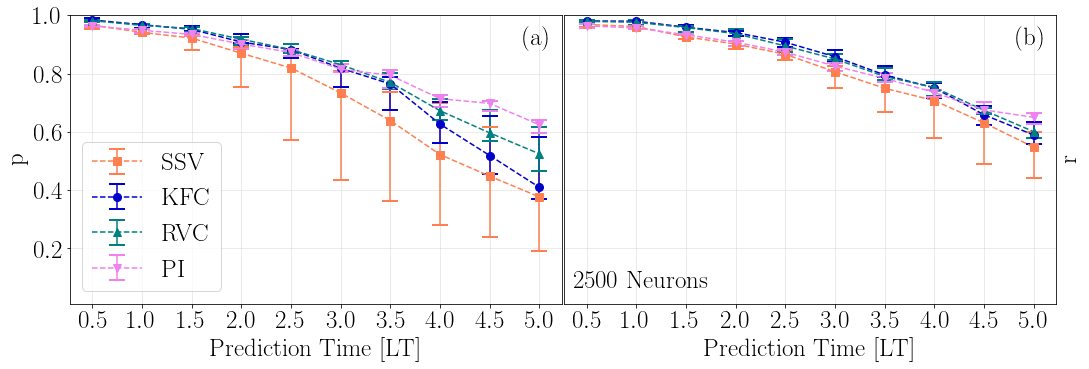

In [80]:
N_units = 2500

fln = './data/KFC_Prec_Recall_'+  str(N_units) +'.h5'
hf = h5py.File(fln,'r')
t_KFC = np.array(hf.get('temp'))
hf.close()

fln = './data/RVC_Prec_Recall_'+  str(N_units) +'.h5'
hf = h5py.File(fln,'r')
t_RVC = np.array(hf.get('temp'))
hf.close()

fln = './data/SSV_Prec_Recall_'+  str(N_units) +'.h5'
hf = h5py.File(fln,'r')
t_SSV = np.array(hf.get('temp'))
hf.close()

fln = './data/RVC_PI2_Prec_Recall_'+  str(N_units) +'.h5'
hf = h5py.File(fln,'r')
t_PI = np.array(hf.get('temp'))
hf.close()

ensemble = t_KFC.shape[0]
LT_range = 10 #t_KFC.shape[1]

p_KFC = np.zeros((ensemble, LT_range))
r_KFC = np.zeros((ensemble, LT_range))
F_KFC = np.zeros((ensemble, LT_range))

p_RVC = np.zeros((ensemble, LT_range))
r_RVC = np.zeros((ensemble, LT_range))
F_RVC = np.zeros((ensemble, LT_range))

p_SSV = np.zeros((ensemble, LT_range))
r_SSV = np.zeros((ensemble, LT_range))
F_SSV = np.zeros((ensemble, LT_range))

p_PI = np.zeros((ensemble, LT_range))
r_PI = np.zeros((ensemble, LT_range))
F_PI = np.zeros((ensemble, LT_range))

logg  = False
fg    = 0
if logg:
    fg = 1

for i in range(ensemble):
    for j in range(LT_range):
        TN,FN,FP,TP,summ = t_KFC[i,j]
        p_KFC[i,j] = np.abs(fg - TP/(TP+FP))
        r_KFC[i,j] = np.abs(fg - TP/(TP+FN))
        F_KFC[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

        TN,FN,FP,TP,summ = t_RVC[i,j]
        p_RVC[i,j] = np.abs(fg - TP/(TP+FP))
        r_RVC[i,j] = np.abs(fg - TP/(TP+FN))
        F_RVC[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

        TN,FN,FP,TP,summ = t_SSV[i,j]
        p_SSV[i,j] = np.abs(fg - TP/(TP+FP))
        r_SSV[i,j] = np.abs(fg - TP/(TP+FN))
        F_SSV[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )
        
        TN,FN,FP,TP,summ = t_PI[i,j]
        p_PI[i,j] = np.abs(fg - TP/(TP+FP))
        r_PI[i,j] = np.abs(fg - TP/(TP+FN))
        F_PI[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

q1 = .25
q2 = 1 - q1

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
plt.subplots(1,2)
plt.subplot(121)
x = .5 + .5*np.arange(LT_range)
plt.xticks(x)

plt.ylim(0.01,1.)
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

plt.errorbar(x, np.median(p_SSV,axis=0), 
             yerr = np.array([np.median(p_SSV,axis=0) - np.quantile(p_SSV,q1,axis=0),
                              - np.median(p_SSV,axis=0) + np.quantile(p_SSV,q2,axis=0)]), 
             linestyle='--',color='coral', marker='s', markersize=8,
             capsize=8, capthick=2, label='SSV', alpha=1)
plt.errorbar(x, np.median(p_KFC,axis=0), 
             yerr = np.array([np.median(p_KFC,axis=0) - np.quantile(p_KFC,q1,axis=0),
                              - np.median(p_KFC,axis=0) + np.quantile(p_KFC,q2,axis=0)]), 
             linestyle='--',color='mediumblue', marker='o', markersize=8,
             capsize=8, capthick=2, label='KFC', alpha=1)

plt.errorbar(x, np.median(p_RVC,axis=0), 
             yerr = np.array([np.median(p_RVC,axis=0) - np.quantile(p_RVC,q1,axis=0),
                              - np.median(p_RVC,axis=0) + np.quantile(p_RVC,q2,axis=0)]), 
             linestyle='--',color='teal', marker='^', markersize=8,
             capsize=8, capthick=2, label='RVC', alpha=1)

plt.errorbar(x, np.median(p_PI,axis=0), 
             yerr = np.array([np.median(p_PI,axis=0) - np.quantile(p_PI,q1,axis=0),
                              - np.median(p_PI,axis=0) + np.quantile(p_PI,q2,axis=0)]), 
             linestyle='--',color='violet', marker='v', markersize=8,
             capsize=8, capthick=2, label='PI', alpha=1)


plt.annotate('(a)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')


plt.ylabel('$\mathrm{p}$')
if logg:
    plt.yscale('log')
    plt.ylabel('1 - $\mathrm{F}$')

plt.legend()
plt.xlabel('Prediction Time [LT]')

ax = plt.subplot(122)
plt.tick_params(axis='y', which='both', left=False,    right=False, labelleft=False)
plt.xticks(x)

plt.ylim(0.01,1.)
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.ylabel('$\mathrm{r}$')
ax.yaxis.set_label_position("right")
plt.errorbar(x, np.median(r_SSV,axis=0), 
             yerr = np.array([np.median(r_SSV,axis=0) - np.quantile(r_SSV,q1,axis=0),
                              - np.median(r_SSV,axis=0) + np.quantile(r_SSV,q2,axis=0)]), 
             linestyle='--',color='coral', marker='s', markersize=8,
             capsize=8, capthick=2, label='SSV', alpha=1)
plt.errorbar(x, np.median(r_KFC,axis=0), 
             yerr = np.array([np.median(r_KFC,axis=0) - np.quantile(r_KFC,q1,axis=0),
                              - np.median(r_KFC,axis=0) + np.quantile(r_KFC,q2,axis=0)]), 
             linestyle='--',color='mediumblue', marker='o', markersize=8,
             capsize=8, capthick=2, label='KFC', alpha=1)

plt.errorbar(x, np.median(r_RVC,axis=0), 
             yerr = np.array([np.median(r_RVC,axis=0) - np.quantile(r_RVC,q1,axis=0),
                              - np.median(r_RVC,axis=0) + np.quantile(r_RVC,q2,axis=0)]), 
             linestyle='--',color='teal', marker='^', markersize=8,
             capsize=8, capthick=2, label='RVC', alpha=1)

plt.errorbar(x, np.median(r_PI,axis=0), 
             yerr = np.array([np.median(r_PI,axis=0) - np.quantile(r_PI,q1,axis=0),
                              - np.median(r_PI,axis=0) + np.quantile(r_PI,q2,axis=0)]), 
             linestyle='--',color='violet', marker='v', markersize=8,
             capsize=8, capthick=2, label='PI', alpha=1)

plt.annotate('(b)', xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')

plt.annotate(str(N_units) + ' Neurons', xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points')

plt.ylabel('$\mathrm{r}$')
if logg:
    plt.yscale('log')
    plt.ylabel('1 - $\mathrm{r}$')
plt.tight_layout(pad=0.1)
plt.xlabel('Prediction Time [LT]')
plt.savefig('pr_MFE2_ensemble'+  str(N_units) +'.pdf')
plt.show()

/home/ar994/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


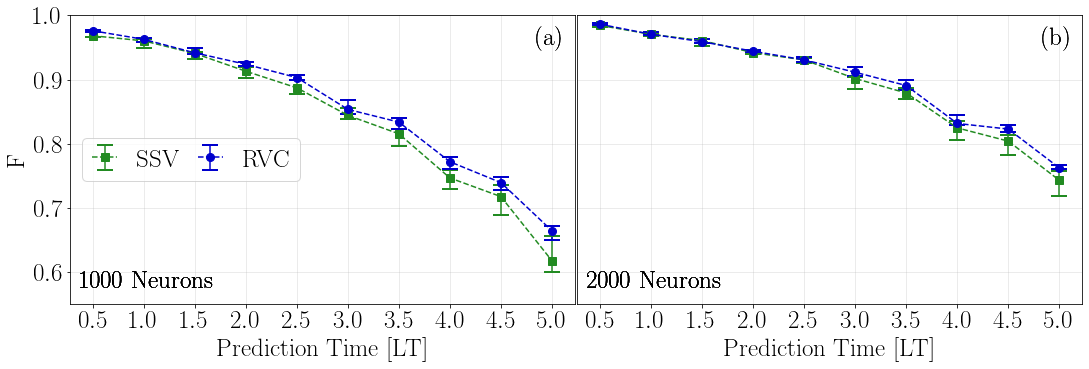

In [52]:
NN_units = [1000,2000]

SNRs      = [40]
target_snr_db = SNRs[0]

vals      = [SSV,RVC]

plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["font.size"] = 25
plt.subplots(len(NN_units)//2,2)

colors  = ['forestgreen', 'mediumblue']
markers = ['s', 'o']
letter  = ['(a)', '(b)']

k_t     = 0
for val in vals:

    for ii in range(len(NN_units)):

        N_units = NN_units[ii]

#         fln = './data/KFC_Prec_Recall_'+  str(N_units) +'.h5'
#         hf = h5py.File(fln,'r')
#         t_KFC = np.array(hf.get('temp'))
#         hf.close()

        fln = './data/'+ val.__name__ +'_Prec_Recall_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        hf = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('temp'))
        hf.close()

#         fln = './data/SSV_Prec_Recall_'+  str(N_units) +'.h5'
#         hf = h5py.File(fln,'r')
#         t_SSV = np.array(hf.get('temp'))
#         hf.close()

#         fln = './data/RVC_PI2_Prec_Recall_'+  str(N_units) +'.h5'
#         hf = h5py.File(fln,'r')
#         t_PI = np.array(hf.get('temp'))
#         hf.close()

        ensemble = t_RVC.shape[0]
        LT_range = t_RVC.shape[1]

        p_KFC = np.zeros((ensemble, LT_range))
        r_KFC = np.zeros((ensemble, LT_range))
        F_KFC = np.zeros((ensemble, LT_range))

        p_RVC = np.zeros((ensemble, LT_range))
        r_RVC = np.zeros((ensemble, LT_range))
        F_RVC = np.zeros((ensemble, LT_range))

        p_SSV = np.zeros((ensemble, LT_range))
        r_SSV = np.zeros((ensemble, LT_range))
        F_SSV = np.zeros((ensemble, LT_range))

        p_PI = np.zeros((ensemble, LT_range))
        r_PI = np.zeros((ensemble, LT_range))
        F_PI = np.zeros((ensemble, LT_range))

        plt.subplot(len(NN_units)//2,2,ii+1)
        x = .5 + .5*np.arange(LT_range)
        plt.xticks(x)

        logg  = False
        fg    = 0
        if logg:
            fg = 1
            plt.yscale('log')
            plt.annotate(str(N_units) + ' Neurons', xy=(0, 1), xytext=(10, -10), va='top', ha='left',
                 xycoords='axes fraction', textcoords='offset points')
        else:
            plt.annotate(str(N_units) + ' Neurons', xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
                 xycoords='axes fraction', textcoords='offset points')

        for i in range(ensemble):
            for j in range(LT_range):
#                 TN,FN,FP,TP,summ = t_KFC[i,j]
#                 p_KFC[i,j] = np.abs(fg - TP/(TP+FP))
#                 r_KFC[i,j] = np.abs(fg - TP/(TP+FN))
#                 F_KFC[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

                TN,FN,FP,TP,summ = t_RVC[i,j]
                p_RVC[i,j] = np.abs(fg - TP/(TP+FP))
                r_RVC[i,j] = np.abs(fg - TP/(TP+FN))
                F_RVC[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

#                 TN,FN,FP,TP,summ = t_SSV[i,j]
#                 p_SSV[i,j] = np.abs(fg - TP/(TP+FP))
#                 r_SSV[i,j] = np.abs(fg - TP/(TP+FN))
#                 F_SSV[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

#                 TN,FN,FP,TP,summ = t_PI[i,j]
#                 p_PI[i,j] = np.abs(fg - TP/(TP+FP))
#                 r_PI[i,j] = np.abs(fg - TP/(TP+FN))
#                 F_PI[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

        q1 = .25
        q2 = 1 - q1


        plt.ylim(0.55,1.)
        plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

#         plt.errorbar(x, np.median(F_SSV,axis=0), 
#                      yerr = np.array([np.median(F_SSV,axis=0) - np.quantile(F_SSV,q1,axis=0),
#                                       - np.median(F_SSV,axis=0) + np.quantile(F_SSV,q2,axis=0)]), 
#                      linestyle='--',color='coral', marker='s', markersize=8,
#                      capsize=8, capthick=2, label='SSV', alpha=1)
#         plt.errorbar(x, np.median(F_KFC,axis=0), 
#                      yerr = np.array([np.median(F_KFC,axis=0) - np.quantile(F_KFC,q1,axis=0),
#                                       - np.median(F_KFC,axis=0) + np.quantile(F_KFC,q2,axis=0)]), 
#                      linestyle='--',color='mediumblue', marker='o', markersize=8,
#                      capsize=8, capthick=2, label='KFC', alpha=1)
        plt.errorbar(x, np.median(F_RVC,axis=0), 
                     yerr = np.array([np.median(F_RVC,axis=0) - np.quantile(F_RVC,q1,axis=0),
                                      - np.median(F_RVC,axis=0) + np.quantile(F_RVC,q2,axis=0)]), 
                     linestyle='--', marker=markers[k_t], markersize=8, c=colors[k_t],
                     capsize=8, capthick=2, label=val.__name__, alpha=1)
#         plt.errorbar(x, np.median(F_PI,axis=0), 
#                      yerr = np.array([np.median(F_PI,axis=0) - np.quantile(F_PI,q1,axis=0),
#                                       - np.median(F_PI,axis=0) + np.quantile(F_PI,q2,axis=0)]), 
#                      linestyle='--',color='violet', marker='v', markersize=8,
#                      capsize=8, capthick=2, label='PI', alpha=1)

        plt.annotate(str(N_units) + ' Neurons', xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
                 xycoords='axes fraction', textcoords='offset points')
        plt.annotate(letter[ii], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')

        if ii == 0:
            plt.legend(ncol=2, columnspacing=0.7, handlelength=1, loc='center left')
        if (ii%2) == 1:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
        else:
            plt.ylabel('$\mathrm{F}$')
        if ii < len(NN_units)-2:
            plt.tick_params(axis='x', which='both', bottom=False,   top=False, labelbottom=False)
        else:
            plt.xlabel('Prediction Time [LT]')
            
    k_t +=1

plt.tight_layout(pad=0.1)
plt.savefig('Noise_F_MFE_ensemble_Neurons.pdf')
plt.show()

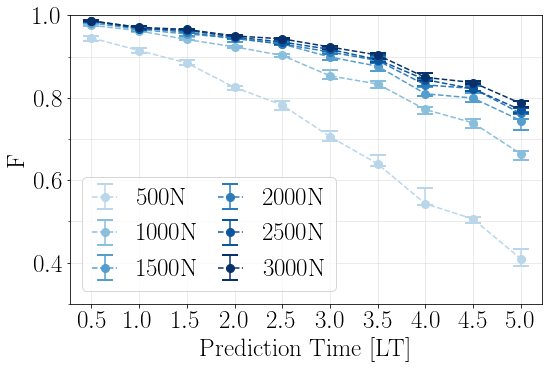

In [39]:
NN_units = [500,1000,1500,2000,2500,3000]

SNRs      = [40]
target_snr_db = SNRs[0]

vals      = [RVC]

plt.rcParams["figure.figsize"] = (7.5,5)
plt.rcParams["font.size"] = 25
plt.subplots(1,1)

colors = [pl.cm.Blues(np.linspace(0,1,len(NN_units)+2))] 
letter = ['(a)', '(b)']

k_t     = 0
for val in vals:
    
    ax = plt.subplot(1,1,k_t+1)

    for ii in range(len(NN_units)):

        N_units = NN_units[ii]

#         fln = './data/KFC_Prec_Recall_'+  str(N_units) +'.h5'
#         hf = h5py.File(fln,'r')
#         t_KFC = np.array(hf.get('temp'))
#         hf.close()

        fln = './data/'+ val.__name__ +'_Prec_Recall_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        hf = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('temp'))
        hf.close()

#         fln = './data/SSV_Prec_Recall_'+  str(N_units) +'.h5'
#         hf = h5py.File(fln,'r')
#         t_SSV = np.array(hf.get('temp'))
#         hf.close()

#         fln = './data/RVC_PI2_Prec_Recall_'+  str(N_units) +'.h5'
#         hf = h5py.File(fln,'r')
#         t_PI = np.array(hf.get('temp'))
#         hf.close()

        ensemble = t_RVC.shape[0]
        LT_range = t_RVC.shape[1]

        p_KFC = np.zeros((ensemble, LT_range))
        r_KFC = np.zeros((ensemble, LT_range))
        F_KFC = np.zeros((ensemble, LT_range))

        p_RVC = np.zeros((ensemble, LT_range))
        r_RVC = np.zeros((ensemble, LT_range))
        F_RVC = np.zeros((ensemble, LT_range))

        p_SSV = np.zeros((ensemble, LT_range))
        r_SSV = np.zeros((ensemble, LT_range))
        F_SSV = np.zeros((ensemble, LT_range))

        p_PI = np.zeros((ensemble, LT_range))
        r_PI = np.zeros((ensemble, LT_range))
        F_PI = np.zeros((ensemble, LT_range))

#         plt.subplot(len(NN_units)//2,2,ii+1)
        x = .5 + .5*np.arange(LT_range)
        plt.xticks(x)

        logg  = False
        fg    = 0
        if logg:
            fg = 1
            plt.yscale('log')


        for i in range(ensemble):
            for j in range(LT_range):
#                 TN,FN,FP,TP,summ = t_KFC[i,j]
#                 p_KFC[i,j] = np.abs(fg - TP/(TP+FP))
#                 r_KFC[i,j] = np.abs(fg - TP/(TP+FN))
#                 F_KFC[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

                TN,FN,FP,TP,summ = t_RVC[i,j]
                p_RVC[i,j] = np.abs(fg - TP/(TP+FP))
                r_RVC[i,j] = np.abs(fg - TP/(TP+FN))
                F_RVC[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

#                 TN,FN,FP,TP,summ = t_SSV[i,j]
#                 p_SSV[i,j] = np.abs(fg - TP/(TP+FP))
#                 r_SSV[i,j] = np.abs(fg - TP/(TP+FN))
#                 F_SSV[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

#                 TN,FN,FP,TP,summ = t_PI[i,j]
#                 p_PI[i,j] = np.abs(fg - TP/(TP+FP))
#                 r_PI[i,j] = np.abs(fg - TP/(TP+FN))
#                 F_PI[i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

        q1 = .25
        q2 = 1 - q1


        plt.ylim(0.3,1.)
        plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

#         plt.errorbar(x, np.median(F_SSV,axis=0), 
#                      yerr = np.array([np.median(F_SSV,axis=0) - np.quantile(F_SSV,q1,axis=0),
#                                       - np.median(F_SSV,axis=0) + np.quantile(F_SSV,q2,axis=0)]), 
#                      linestyle='--',color='coral', marker='s', markersize=8,
#                      capsize=8, capthick=2, label='SSV', alpha=1)
#         plt.errorbar(x, np.median(F_KFC,axis=0), 
#                      yerr = np.array([np.median(F_KFC,axis=0) - np.quantile(F_KFC,q1,axis=0),
#                                       - np.median(F_KFC,axis=0) + np.quantile(F_KFC,q2,axis=0)]), 
#                      linestyle='--',color='mediumblue', marker='o', markersize=8,
#                      capsize=8, capthick=2, label='KFC', alpha=1)
        plt.errorbar(x, np.median(F_RVC,axis=0), 
                     yerr = np.array([np.median(F_RVC,axis=0) - np.quantile(F_RVC,q1,axis=0),
                                      - np.median(F_RVC,axis=0) + np.quantile(F_RVC,q2,axis=0)]), 
                     linestyle='--', marker='o', markersize=8, c=colors[0][ii+2],
                     capsize=8, capthick=2, label=str(N_units) + 'N', alpha=1)
#         plt.errorbar(x, np.median(F_PI,axis=0), 
#                      yerr = np.array([np.median(F_PI,axis=0) - np.quantile(F_PI,q1,axis=0),
#                                       - np.median(F_PI,axis=0) + np.quantile(F_PI,q2,axis=0)]), 
#                      linestyle='--',color='violet', marker='v', markersize=8,
#                      capsize=8, capthick=2, label='PI', alpha=1)

    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))

    if k_t == 0:
        plt.legend(ncol=2, columnspacing=0.7, handlelength=1, loc='lower left')
    if (k_t%2) == 1:
        plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)
    else:
        plt.ylabel('$\mathrm{F}$')
    if k_t < len(SNRs)-2:
        plt.tick_params(axis='x', which='both', bottom=False,   top=False, labelbottom=False)
    else:
        plt.xlabel('Prediction Time [LT]')

#     plt.annotate(letter[k_t], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
#              xycoords='axes fraction', textcoords='offset points')
#     plt.annotate(val.__name__, xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
#              xycoords='axes fraction', textcoords='offset points')



            
    k_t +=1
    
plt.tight_layout(pad=0.1)
plt.savefig('Noise_F_MFE_ensemble.pdf')
plt.show()

/home/ar994/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ar994/.local/lib/python3.6/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(10, 10, 5)


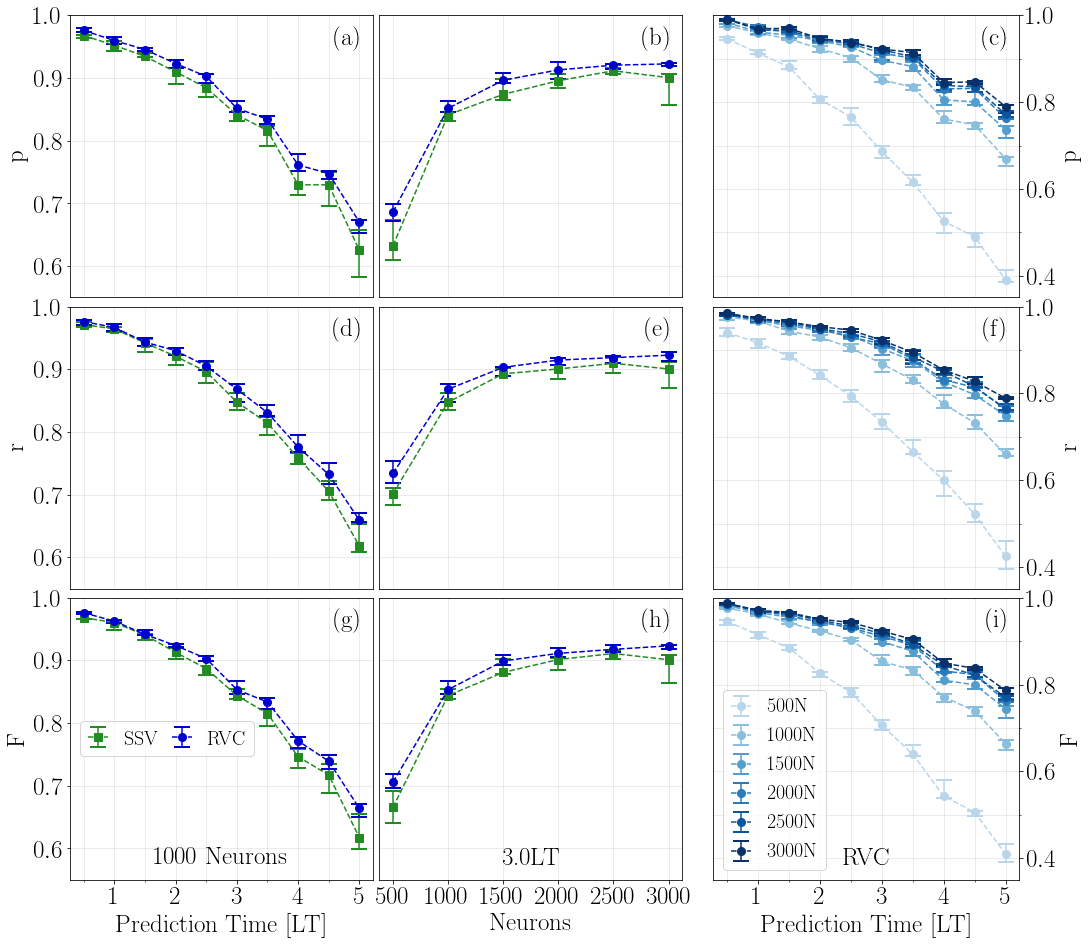

In [79]:
NN_units = [1000]

SNRs      = [40]
target_snr_db = SNRs[0]

vals      = [SSV,RVC]

from matplotlib.gridspec import *
plt.rcParams["figure.figsize"] = (15,13)
plt.rcParams["font.size"] = 25

colors  = ['forestgreen', 'mediumblue']
markers = ['s', 'o']
letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']

pr_max = 3
labels_pr = ['p','r','F']
axx = plt.figure()
gs = GridSpec(pr_max, 2, width_ratios=[2., 1.], figure=axx, wspace=0.1,hspace=0.02)

gss = [None]*pr_max

for pr in range(pr_max):
    gss[pr] = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.], subplot_spec=gs[pr*2],
                                     wspace=0.02)

# gs00 = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.2], subplot_spec=gs[0], wspace=0.05)
# gs01 = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.2], subplot_spec=gs[2], wspace=0.05)
# gs02 = GridSpecFromSubplotSpec(1, 2, width_ratios=[1., 1.2], subplot_spec=gs[4], wspace=0.05)

# gss  = [gs00,gs01,gs02]

logg  = False
fg    = 0
if logg:
    fg = 1

k_t     = 0
for val in vals:

    for ii in range(len(NN_units)):

        N_units = NN_units[ii]

        fln = './data/'+ val.__name__ +'_Prec_Recall_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        hf = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('temp'))
        hf.close()


        ensemble = t_RVC.shape[0]
        LT_range = t_RVC.shape[1]

        p_RVC = np.zeros((ensemble, LT_range))
        r_RVC = np.zeros((ensemble, LT_range))
        F_RVC = np.zeros((ensemble, LT_range,3))

        x = .5 + .5*np.arange(LT_range)
        xx = x.copy()

        for i in range(ensemble):
            for j in range(LT_range):

                TN,FN,FP,TP,summ = t_RVC[i,j]
                F_RVC[i,j,0] = np.abs(fg - TP/(TP+FP))
                F_RVC[i,j,1] = np.abs(fg - TP/(TP+FN))
                F_RVC[i,j,2] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

        q1 = .25
        q2 = 1 - q1

        for pr in range(pr_max):
            
            ax = axx.add_subplot(gss[pr][0])
#             ax = plt.subplot(pr_max,3,1 + 3*pr)
            if pr < pr_max-1:
                plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
            
            plt.ylim(0.55,1.)
            plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))

            plt.errorbar(x, np.median(F_RVC[:,:,pr],axis=0), 
                         yerr = np.array([np.median(F_RVC[:,:,pr],axis=0) - np.quantile(F_RVC[:,:,pr],q1,axis=0),
                                          - np.median(F_RVC[:,:,pr],axis=0) + np.quantile(F_RVC[:,:,pr],q2,axis=0)]), 
                         linestyle='--', marker=markers[k_t], markersize=8, c=colors[k_t],
                         capsize=8, capthick=2, label=val.__name__, alpha=1)

            
            if k_t == 0 and ii == 0:
                plt.annotate(letter[0+3*pr], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')

            
            plt.ylabel(labels_pr[pr])
            
        plt.xlabel('Prediction Time [LT]')
        plt.xticks(x[1::2])

        k_t +=1

plt.annotate(str(N_units) + ' Neurons', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
     xycoords='axes fraction', textcoords='offset points')
plt.legend(ncol=2, columnspacing=0.7, handlelength=1, loc='center left', fontsize=20)

    
    

NN_units  = [500,1000,1500,2000,2500,3000]
un_length = len(NN_units)

print(t_RVC.shape)

k = 0
N_LT   = 10
t1_RVC = np.zeros((un_length,t_RVC.shape[0],N_LT,t_RVC.shape[2]))
t1_SSV = np.zeros((un_length,t_RVC.shape[0],N_LT,t_RVC.shape[2]))

colors  = ['forestgreen', 'mediumblue']
markers = ['s', 'o']

for N_units in NN_units:


    fln = './data/RVC_Prec_Recall_40_'+  str(N_units) +'.h5'
    hf = h5py.File(fln,'r')
    t1_RVC[k] = np.array(hf.get('temp'))[:,:N_LT]
    hf.close()

    fln = './data/SSV_Prec_Recall_40_'+  str(N_units) +'.h5'
    hf = h5py.File(fln,'r')
    t1_SSV[k] = np.array(hf.get('temp'))[:,:N_LT]
    hf.close()

    
    k +=1

ensemble = t1_RVC.shape[1]
LT_range = t1_RVC.shape[2]


p_RVC = np.zeros((un_length,ensemble, LT_range))
r_RVC = np.zeros((un_length,ensemble, LT_range))
F_RVC = np.zeros((3,un_length,ensemble, LT_range))

p_SSV = np.zeros((un_length,ensemble, LT_range))
r_SSV = np.zeros((un_length,ensemble, LT_range))
F_SSV = np.zeros((3,un_length,ensemble, LT_range))


logg  = False
fg    = 0
if logg:
    fg = 1

for k in range(un_length):
    for i in range(ensemble):
        for j in range(LT_range):

            TN,FN,FP,TP,summ = t1_RVC[k,i,j]
            F_RVC[0,k,i,j] = np.abs(fg - TP/(TP+FP))
            F_RVC[1,k,i,j] = np.abs(fg - TP/(TP+FN))
            F_RVC[2,k,i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )

            TN,FN,FP,TP,summ = t1_SSV[k,i,j]
            F_SSV[0,k,i,j] = np.abs(fg - TP/(TP+FP))
            F_SSV[1,k,i,j] = np.abs(fg - TP/(TP+FN))
            F_SSV[2,k,i,j] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )
            

            
PLT = 5
q1  = .25
q2  = 1 - q1

x = NN_units

for pr in range(pr_max):
    
    ax = axx.add_subplot(gss[pr][1])
#     ax = plt.subplot(3,3,2+pr*3)
    if pr < pr_max-1:
                plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
    plt.xticks(x)

    plt.ylim(.55,1)
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
    plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
    plt.tick_params(axis='y', which='major', left=False, right=False, labelleft=False)

    plt.errorbar(x, np.median(F_SSV[pr,:,:,PLT],axis=1), 
             yerr = np.array([np.median(F_SSV[pr,:,:,PLT],axis=1) - np.quantile(F_SSV[pr,:,:,PLT],q1,axis=1),
                              - np.median(F_SSV[pr,:,:,PLT],axis=1) + np.quantile(F_SSV[pr,:,:,PLT],q2,axis=1)]), 
             linestyle='--',color=colors[0], marker=markers[0], markersize=8,
             capsize=8, capthick=2, label='SSV', alpha=1)


    plt.errorbar(x, np.median(F_RVC[pr,:,:,PLT],axis=1), 
             yerr = np.array([np.median(F_RVC[pr,:,:,PLT],axis=1) - np.quantile(F_RVC[pr,:,:,PLT],q1,axis=1),
                              - np.median(F_RVC[pr,:,:,PLT],axis=1) + np.quantile(F_RVC[pr,:,:,PLT],q2,axis=1)]), 
             linestyle='--',color=colors[1], marker=markers[1], markersize=8,
             capsize=8, capthick=2, label='RVC', alpha=1)


    plt.annotate(letter[1+3*pr], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
             xycoords='axes fraction', textcoords='offset points')


# plt.ylabel('$\mathrm{F}$')


plt.xlabel('Neurons')

plt.annotate(str(xx[PLT]) + 'LT', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
             xycoords='axes fraction', textcoords='offset points')



NN_units = [500,1000,1500,2000,2500,3000]

SNRs      = [40]
target_snr_db = SNRs[0]

vals      = [RVC]


colors = [pl.cm.Blues(np.linspace(0,1,len(NN_units)+2))] 

k_t     = 0
for val in vals:

    for ii in range(len(NN_units)):

        N_units = NN_units[ii]

        fln = './data/'+ val.__name__ +'_Prec_Recall_'+ str(target_snr_db) + '_'+  str(N_units) +'.h5'
        hf = h5py.File(fln,'r')
        t_RVC = np.array(hf.get('temp'))
        hf.close()

        ensemble = t_RVC.shape[0]
        LT_range = t_RVC.shape[1]

        p_RVC = np.zeros((ensemble, LT_range))
        r_RVC = np.zeros((ensemble, LT_range))
        F_RVC = np.zeros((ensemble, LT_range,3))

        x = .5 + .5*np.arange(LT_range)

        logg  = False
        fg    = 0
        if logg:
            fg = 1
            plt.yscale('log')


        for i in range(ensemble):
            for j in range(LT_range):

                TN,FN,FP,TP,summ = t_RVC[i,j]
                F_RVC[i,j,0] = np.abs(fg - TP/(TP+FP))
                F_RVC[i,j,1] = np.abs(fg - TP/(TP+FN))
                F_RVC[i,j,2] = np.abs(fg - 2/(1/(TP/(TP+FP))+1/(TP/(TP+FN))) )


        q1 = .25
        q2 = 1 - q1

        for pr in range(pr_max):
            
            ax = axx.add_subplot(gs[1+2*pr])
#             ax = plt.subplot(3,3,3+pr*3)
            if pr < pr_max-1:
                plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)
            plt.ylim(0.35,1.)
            plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)

            plt.errorbar(x, np.median(F_RVC[:,:,pr],axis=0), 
                         yerr = np.array([np.median(F_RVC[:,:,pr],axis=0) - np.quantile(F_RVC[:,:,pr],q1,axis=0),
                                          - np.median(F_RVC[:,:,pr],axis=0) + np.quantile(F_RVC[:,:,pr],q2,axis=0)]), 
                         linestyle='--', marker='o', markersize=8, c=colors[0][ii+2],
                         capsize=8, capthick=2, label=str(N_units) + 'N', alpha=1)

            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
            ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.1))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))
            plt.ylabel(labels_pr[pr])
            if k_t == 0 and ii == 0:
                plt.annotate(letter[2+3*pr], xy=(1, 1), xytext=(-10, -10), va='top', ha='right',
                 xycoords='axes fraction', textcoords='offset points')

    plt.legend(ncol=1, columnspacing=0.7, handlelength=1, loc='lower left', fontsize=20)
    plt.xlabel('Prediction Time [LT]')
    plt.xticks(x[1::2])

#     plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False)      
            
    k_t +=1

plt.annotate('RVC', xy=(.5, 0), xytext=(0, 10), va='bottom', ha='center',
             xycoords='axes fraction', textcoords='offset points')
    

gs.tight_layout(axx,pad=.1,w_pad=0.8,h_pad=0.02)
plt.savefig('Prec_Rec_comparison1.pdf')

In [ ]:
NN_units = [1000,1500,2000,2500,3000]
vals     = [RVC]
SNRs     = [40,30]
ensemble = 10

un_length  = len(NN_units)
vl_length  = len(vals)
snr_length = len(SNRs)

q1        = .25
q2        = 1 - q1

new       = True

N_range=(0.005,0.48)
N_rang1=(N_range[0]+0.01,N_range[1]-0.01)

fln       = './data/Stats_' + str(N_rang1) + '.h5'
hf        = h5py.File(fln,'r')
errors    = np.array(hf.get('rel-err'))
hists     = np.array(hf.get('bins'))
y         = np.array(hf.get('edges'))
n         = np.array(hf.get('true'))
nn        = np.array(hf.get('train'))
n1        = np.array(hf.get('short'))
hf.close()

bins      = n.shape[0]

markers = ['s', 'o', '^', 'v']
labels  = [ str(SNRs[i]) for i in range(len(SNRs))]
colors  = ['coral', 'mediumblue', 'teal', 'violet']


plt.rcParams["figure.figsize"] = (12,4*len(NN_units))
plt.rcParams["font.size"] = 25

if new:
    n_new = (n[::2]+n[1::2])/2
    y     = y[1::2]
else:
    n_new = n
    y     = y[:-1] + (y[1]-y[0])/2


for i in range(un_length):
    
    plt.subplot(len(NN_units),1,i+1)
    
    plt.plot(y, n_new, label='True', linewidth=8, c='black')
    
    for k in range(snr_length):
    
        for j in range(vl_length):
            errr = errors[:,i,j,k].copy()
            errr[np.where(errr == 0)[0]] = 10
            histmin = hists[np.argsort(errr)[ensemble//2-1] ,i,j,k]
#             histmin = hists[np.argmin(errr),i,j,k]
            if new:
                hist_new = (histmin[::2]+histmin[1::2])/2
            else:
                hist_new = histmin.copy()

            print(labels[k], NN_units[i], (np.abs(hist_new-n_new)/n_new).mean())
            plt.plot(y, hist_new, c=colors[k], label=labels[k],
                    linewidth=3)
    
    if new:
        nn_new = (nn[::2]+nn[1::2])/2
    else:
        nn_new = nn
    plt.plot(y, nn_new, '--C4', label='Train', linewidth=3, alpha=.5)
    print('Train', (np.abs(nn_new-n_new)/n_new).mean())
    
    plt.annotate(str(NN_units[i]) + ' Neurons', xy=(0, 0), xytext=(10, 10), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points')
    plt.ylim(0.01,100)
    plt.yscale('log')
    
    if i == len(NN_units)-1:
        plt.xlabel('Kinetic Energy')
    else:
        plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)

plt.legend(ncol=2)
plt.tight_layout(pad=0.1)


plt.rcParams["figure.figsize"] = (10,9)
plt.rcParams["font.size"] = 25
plt.figure()
plt.subplot(2,1,1)

err_train = sc.stats.wasserstein_distance(n, nn)
err_short = sc.stats.wasserstein_distance(n, n1)
plt.axhline(err_train, c='C4', linestyle='--')
# plt.axhline(err_short, c='k')

plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.tick_params(axis='x', which='both', top=False,bottom=False, labelbottom=False)


for j in range(vl_length):
    a           = np.zeros(un_length)
    for l in range(snr_length):
        for i in range(un_length):
            errr    = np.zeros(ensemble)
            for k in range(ensemble):
                errr[k]  = sc.stats.wasserstein_distance(n, hists[k,i,j,l])
            errr    = errr[np.nonzero(hists[:,i,j])[0]]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[l], marker=markers[l], markersize=8,
                 capsize=8, capthick=2, label=labels[l], alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[l])
    plt.annotate(str(np.array(N_rang1)), xy=(0, 0), xytext=(10, 20), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points',fontsize=20)

plt.ylabel('Wasserstein')
plt.subplot(2,1,2)

err_train = (np.abs(nn-n)/n).mean()
err_short = (np.abs(n1-n)/n).mean()
plt.axhline(err_train, c='C4', linestyle='--', label='Train')
# plt.axhline(err_short, c='k')
plt.yscale('log')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)


for j in range(vl_length):
    a           = np.zeros(un_length)
    for l in range(snr_length):
        for i in range(un_length):
            errr    = errors[:,i,j,l].copy()
            errr[np.where(errr == 0)[0]] = 10
            errr    = errr[np.nonzero(errr)[0]]
            a[i]    = np.median(errr,axis=0)
            a1      = np.quantile(errr,q1,axis=0)
            a2      = np.quantile(errr,q2,axis=0)
            if i==0:
                plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[l], marker=markers[l], markersize=8,
                 capsize=8, capthick=2, label=labels[l], alpha=1)
            else:
                plt.errorbar(NN_units[i], a[i], 
                 yerr = np.array([a[i] - a1, a2 - a[i]]).reshape(2,1), 
                 linestyle='--', c=colors[l], marker=markers[l], markersize=8,
                 capsize=8, capthick=2, alpha=1)
        plt.plot(NN_units, a, linestyle='--', c=colors[l])
    plt.annotate(str(np.array(N_rang1)), xy=(0, 0), xytext=(10, 20), va='bottom', ha='left',
             xycoords='axes fraction', textcoords='offset points',fontsize=20)

plt.xlabel('Neurons')
plt.ylabel('Mean Relative Error')
# plt.ylim(0.25,1.5)
plt.legend(ncol=3, columnspacing=0.8, handlelength=0.8)
plt.tight_layout()
plt.savefig('Rel_Error_' + str(np.array(N_rang1)) + '.pdf')
